------
### Exercise 6 - Markov Chain Monte Carlo

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from collections import Counter
from scipy import stats

###  1 - Metropolis-Hastings

$P(i) = c \cdot \frac{A^i}{i!},\ i = 0,...,m$

Generating values from this distribution by applying the Metropolis-Hastings algorithm,


In [294]:
def metropolis_hastings(n=10000, A=8, m=10):
    
    g = lambda x: (A**x)/factorial(x)

    X = np.zeros(n)
    
    for i in range(n-1):

        
        x_current = X[i]

        x_proposed = np.random.randint(0, m + 1)
        
        acceptance_probability = min(1, g(x_proposed)/g(x_current))

        u = np.random.uniform(0,1)
        
        if u <= acceptance_probability:
            X[i+1] = x_proposed
        else:
            X[i+1] = x_current
    return X

Simulating values, and finding probability distribution

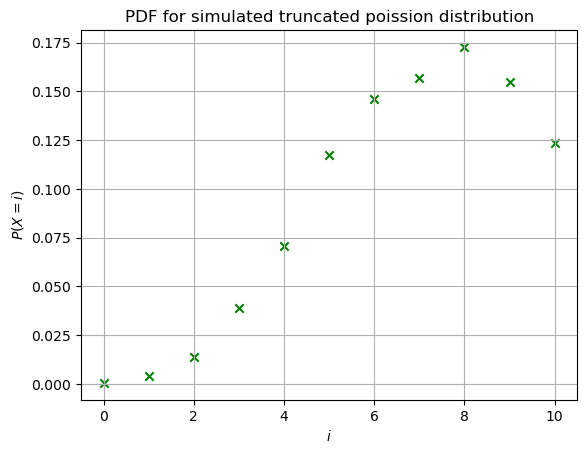

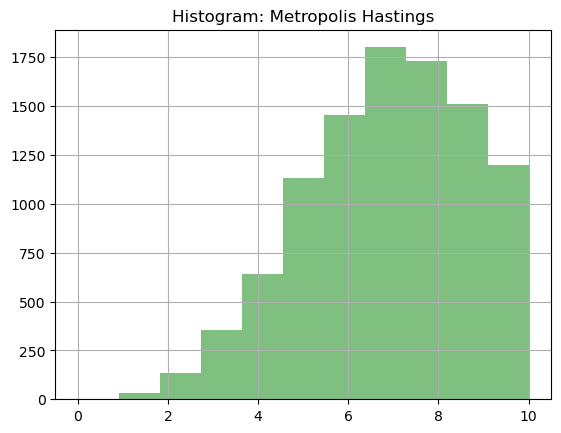

In [295]:
n = 10000

X = metropolis_hastings(n)

def make_pdf(sample):
    
    n = len(sample)
    c = [(k, v) for k,v in Counter(sample).items()]
    c = sorted(c, key = lambda x: x[0])
    pdf = []
    indices = []
    for x in c:
        
        i, count = x[0], x[1]
        indices.append(i)
        pdf.append(count/n)

    return indices, pdf

indices, pdf = make_pdf(X)
plt.scatter(indices,pdf, marker="x", color="g")
plt.grid()
plt.xlabel(r"$i$")
plt.title("PDF for simulated truncated poission distribution")
plt.ylabel(r"$P(X=i)$")
plt.show()

plt.hist(vals, bins=11, color="g", alpha=0.5)
plt.title("Histogram: Metropolis Hastings")
plt.grid()
plt.show()

Verifying visually and with $\chi^2$:

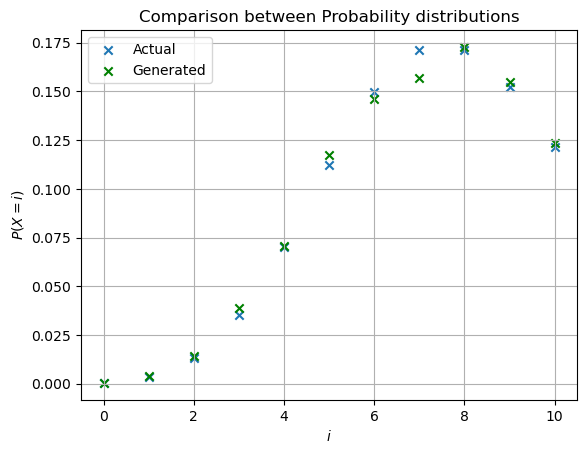

Test statistic: 21.760066682742384
P-value: 0.016374673048336598


In [296]:
from scipy.stats import chisquare


def true_pdf(m, n):
    pdf = []
    for i in range(10+1):
        pdf.append((8**i)/factorial(i))
    return [i/sum(pdf) for i in pdf]

plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.scatter(indices,pdf, marker="x",label="Generated", color="g")
plt.grid()
plt.xlabel(r"$i$")
plt.title("Comparison between Probability distributions")
plt.legend(loc='upper left')
plt.ylabel(r"$P(X=i)$")
plt.show() 

# Proceeding with chi-2 test

chisq, p = chisquare(f_obs=[i*10000 for i in pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")
    

Attempting to generate more acceptable sample, by thinning generated sample

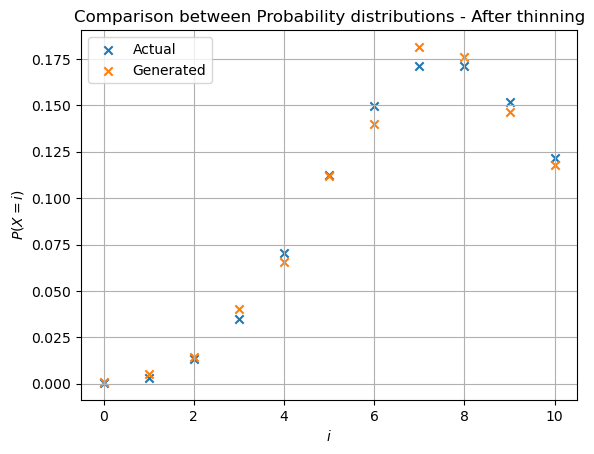

Test statistic: 4.35201333654848
P-value: 0.9300730922129283


In [297]:
thinned_sample = thin(vals, 5)

thinned_indices, thinned_pdf = make_pdf(thinned_sample)

plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.scatter(thinned_indices,thinned_pdf, marker="x",label="Generated")
plt.grid()
plt.xlabel(r"$i$")
plt.title("Comparison between Probability distributions - After thinning")
plt.legend(loc='upper left')
plt.ylabel(r"$P(X=i)$")
plt.show() 

chisq, p = chisquare(f_obs=[i*len(thinned_sample) for i in pdf], f_exp=[i*len(thinned_sample) for i in true_pdf(8, 10)])
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")

Thinning has increased the *p-value* dramatically

Collecting multiple (1000) samples, conducting $\chi^2$ test, collecting p-values and seeing how many samples result in an accepted null hypothesis.

- For original, unthinned samples
- For samples with thinning parameter 3
- Samples with thinning parameter 5

In [208]:
p_vals_original, p_vals_3, p_vals_5 = [], [], []

def do_chi2(observed_sample):
    expected = [i*len(observed_sample) for i in true_pdf(8, 10)]
    _, pdf = make_pdf(observed_sample)
    observed = [i*len(observed_sample) for i in pdf]

    _, p = chisquare(f_obs=observed, f_exp=expected)
    return p



for i in range(100):
    n_original = 10000
    vals_original = MH(n)
    thinned_3 = thin(vals_original, 3)
    thinned_5 = thin(vals_original, 5)

    p, p_3, p_5 = do_chi2(vals_original), do_chi2(thinned_3), do_chi2(thinned_5)


    p_vals_original.append(p)
    p_vals_3.append(p_3)
    p_vals_5.append(p_5)

print(f"Percentage of original samples that pass chi-squared test (5%): {100*round(len([i for i in p_vals_original if i > 0.05])/len(p_vals_original), 2)}%")
print(f"Percentage of samples (thinned with parameter 3) that pass chi-squared test: {100*round(len([i for i in p_vals_3 if i > 0.05])/len(p_vals_3), 2)}%")
print(f"Percentage of original samples (thinned with parameter 5) that pass chi-squared test: {100*round(len([i for i in p_vals_5 if i > 0.05])/len(p_vals_5), 2)}%")


Percentage of original samples that pass chi-squared test (5%): 59.0%
Percentage of samples (thinned with parameter 3) that pass chi-squared test: 89.0%
Percentage of original samples (thinned with parameter 5) that pass chi-squared test: 92.0%


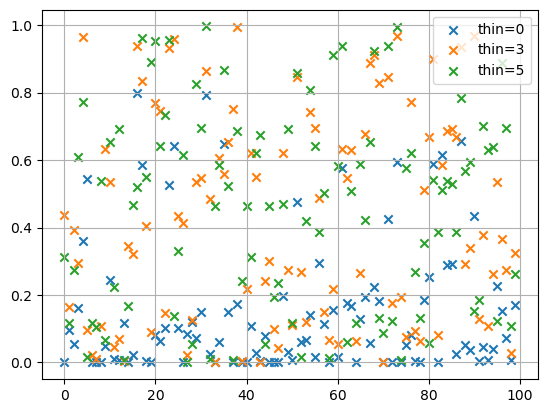

In [244]:
plt.scatter([i for i in range(len(p_vals_original))], p_vals_original, marker="x", label="thin=0")
plt.scatter([i for i in range(len(p_vals_3))], p_vals_3, marker="x", label="thin=3")
plt.scatter([i for i in range(len(p_vals_5))], p_vals_5, marker="x", label="thin=5")
plt.legend()
plt.grid()
plt.show()

As can be seen above, thinning the sample drastically increases its quality, with respect to the $\chi^2$ test

### 2 - Joint Distribution



$P(i,j) = c \cdot \frac{A^{i}_{1}}{i!} \frac{A^{j}_{2}}{j!}, \ 0 \leq i+j \leq m$

where $A_1, \ A_2 = 4 \text{ and } m = 10$


#### (a) Using Metropolis-Hastings Directly

In [298]:
def MH2(n=10000, m=10):

    A1, A2 = 4, 4
    
    g = lambda x, y: ((A1**x)/factorial(x)) * ((A2**y)/factorial(y))

    
    
    X, Y = np.zeros(n), np.zeros(n)

    for i in range(n-1):
        
        current_X, current_Y = X[i], Y[i]
        
        proposed_X = np.random.randint(0, m+1)
        proposed_Y = np.random.randint(0, m+1 - proposed_X)
        
        acceptance_probability = min(1, g(proposed_X, proposed_Y)/g(current_X, current_Y))

        u = np.random.uniform()
        if u <= acceptance_probability:
            
            X[i+1], Y[i+1] = proposed_X, proposed_Y
        
        else:
        
            X[i+1], Y[i+1] = current_X, current_Y

    return X, Y

Simulating sample

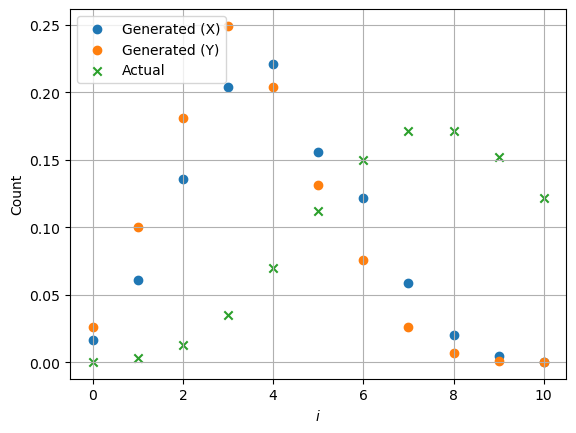

In [300]:
X1, Y1 = MH2()

X1_i, X1_p = make_pdf(X1)
Y1_i, Y1_p = make_pdf(Y1)

plt.scatter(X1_i, X1_p, label= "Generated (X)")
plt.scatter(Y1_i, Y1_p, label="Generated (Y)")
plt.scatter([i for i in range(0, 11)],[i for i in true_pdf(8, 10)], marker="x", label="Actual")
plt.ylabel("Count")
plt.grid()
plt.xlabel(r"$i$")
plt.legend(loc='upper left')
plt.show()

Conducting $\chi^2$ test

In [257]:
chisq, p = chisquare(f_obs=[i*10000 for i in X_pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")

Test statistic: 52901.975056162395
P-value: 0.0


Thinning sample and performing $\chi^2$ test

In [258]:
X1_thin_3 = thin(X1, 3)
p = do_chi2(X1_thin_3)
print(p)

0.0


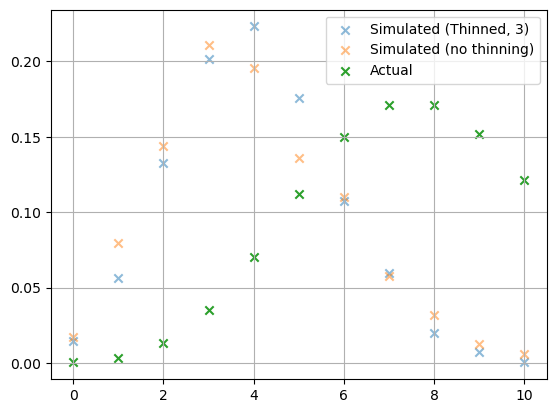

In [259]:
plt.scatter(list(range(11)), make_pdf(X1_thin_3)[1], marker="x", label="Simulated (Thinned, 3)",alpha=0.5)
plt.scatter(list(range(11)), X_pdf, marker="x", label="Simulated (no thinning)",alpha=0.5)
plt.scatter(list(range(11)), true_pdf(8, 10), marker="x", label="Actual")
plt.legend()
plt.grid()
plt.show()

Again, thinning the sample increases the similarity between the generated and actual distributions.


#### (b) Metropolis-Hastings Coordinate-Wise

Creating probability matrix

In [284]:
def create_probability_matrix(A1=4, A2=4, m=10):
    
    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    M = np.zeros(shape=(m+1, m+1))
    s = 0

    for i in range(m+1):
        for j in range(m+1):
            if i+j <=m:
                M[i][j] = g(i, j)
                s += g(i, j)

    return M/s

Coordinate-wise Metropolis-Hastings 

In [261]:
# def MH_coord(n, A1=4, A2=4,m=10):

#     g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    
#     X, Y = np.zeros(n), np.zeros(n)

#     M = create_probability_matrix()
    
#     # Initial coordinates

#     X[0] = np.random.randint(0, m+1)
#     Y[0] = np.random.randint(0, m+1)

#     for l in range(n-1):

#         current_X, current_Y = int(X[i]), int(Y[i])

#         # Updating X coordinate
        
#         x_probability = M[current_Y] / sum(M[current_Y]) # Probabilities of moving to a different x 
#         new_X = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=x_probability)[0]

#         # Updating Y coordinate

#         y_probability = M[:,new_X] / sum(M[:,new_X])
#         new_Y = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=y_probability)[0]
        
#         acceptance_probability = min(1, g(new_X, new_Y)/g(current_X, current_Y))
        

#         # Checking acceptance criteria

#         u = np.random.uniform()
#         if u <= acceptance_probability:
            
#             X[i+1], Y[i+1] = new_X, new_Y
        
#         else:
        
#             X[i+1], Y[i+1] = current_X, current_Y
    
#     return X, Y

In [285]:
def MH_coord(n=10000, m=10, A1=4, A2=4):

    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))

    X, Y = np.zeros(n), np.zeros(n)
    
    Y[0] = np.random.randint(0, m + 1)
    
    M = create_probability_matrix()
    
    for i in range(n):        
        
        x_probability = M[int(Y[i])] / sum(M[int(Y[i])]) # Probabilities of moving to a different x
        new_x = np.random.choice(list(range(11)), p=x_probability)
        
        y_probability = M[:,int(new_x)] / sum(M[:,int(new_x)])
        new_y = np.random.choice(list(range(11)), p=y_probability)
        
        X[i] = new_x
        Y[i] = new_y

    return (X, Y)


Generating sample

In [286]:
X_c, Y_c = MH_coord(10000)


Verifying visually

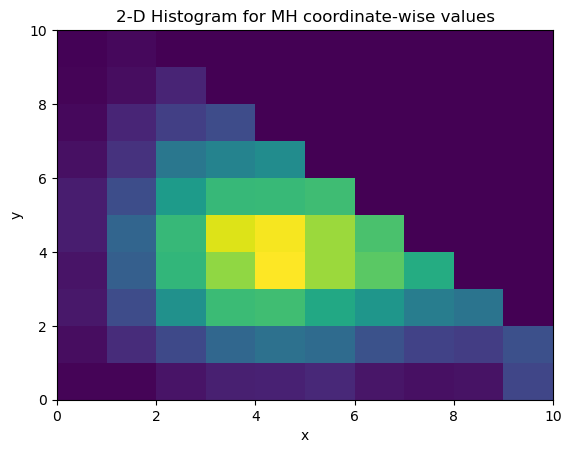

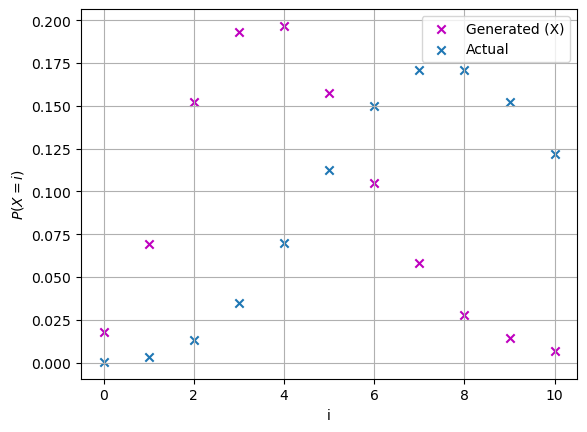

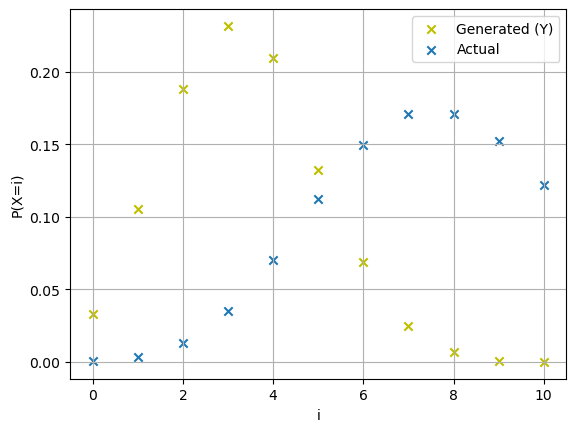

In [290]:
# i_x, pdf_X_c = make_pdf(X_c)
# i_Y, pdf_Y_c = make_pdf(Y_c)


plt.hist2d(X_c, Y_c)
plt.title("2-D Histogram for MH coordinate-wise values")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


i_x, pdf_X_c = make_pdf(X_c)
i_Y, pdf_Y_c = make_pdf(Y_c)


plt.scatter(i_x, pdf_X_c, marker="x", color="m", label="Generated (X)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.ylabel(r"$P(X=i)$")
plt.xlabel(r"i")
plt.legend()
plt.grid()
plt.show()

plt.scatter(i_Y, pdf_Y_c, marker="x", color="y", label="Generated (Y)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.legend()
plt.grid()
plt.ylabel(r"P(X=i)")
plt.xlabel(r"i")
plt.legend()
plt.show()


Performing $\chi^2$ test on X generated by MH coordinate-wise

In [288]:
chisq, p = chisquare(f_obs=[i*10000 for i in pdf_X_c], f_exp=[i*10000 for i in true_pdf(8, 10)])
print("chi squared test: X")
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")

chi squared test: X
Test statistic: 50655.169669782925
P-value: 0.0


In [289]:
chisq, p = chisquare(f_obs=[i*10000 for i in pdf_Y_c], f_exp=[i*10000 for i in true_pdf(8, 10)])
print("chi squared test: Y")
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")

chi squared test: Y
Test statistic: 95860.57219701575
P-value: 0.0


Thinning sample

In [ ]:
_, X_c_thin_pdf = make_pdf(thin(X_c, 3))
chisq, p = chisquare(f_obs=[i*10000 for i in X_c_thin_pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")

Same test statistic and p-value generated, irrespective of thinning parameter.

Unsure as to why this occurs - However visually the Generated samples appear to have similar probability densities to the reference distribution.

#### (c) Use Gibbs sampling 



In [291]:
def gibbs(n, A1=4, A2=4, m=10):

    X, Y = np.zeros(n), np.zeros(n)

    g = lambda i, j: ((A1**i)/factorial(i)) * ((A2**j)/factorial(j))
    M = create_probability_matrix()
    
    # Functions for calculating conditional probability

    px_given_y = lambda x, y: M[y][x]/sum(M[y])
    py_given_x = lambda x, y: M[y][x]/sum(M[:, x])
    
    # Randomly selecting start state
    
    X[0], Y[0] = np.random.randint(0, m+1), np.random.randint(0, m+1)

    for i in range(n-1):

        current_y = int(Y[i])

        # Updating x 

        vals = [px_given_y(j, current_y) for j in range(m+1)]
        probabilities = [val/sum(vals) for val in vals] # Distribution of conditional probabilities P(X=i|current Y) 
        new_X = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=probabilities)[0]

        # Updating y

        vals = [py_given_x(new_X, j) for j in range(m+1)]
        probabilities = [val/sum(vals) for val in vals] # Distribution of conditional probabilities P(Y=j|new X)
        new_Y = np.random.choice([l for l in range(m+1)], size=1, replace=True, p=probabilities)[0]

        # Inserting into samples
        X[i+1], Y[i+1] = new_X, new_Y
    
    return X, Y

Obtaining samples

In [292]:
X_gibbs, Y_gibbs = gibbs(10000)

Displaying distributions

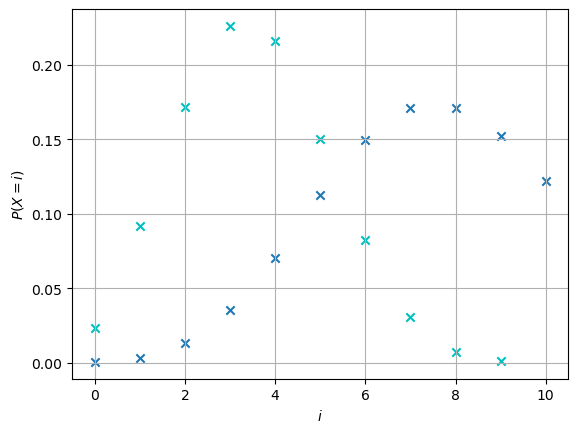

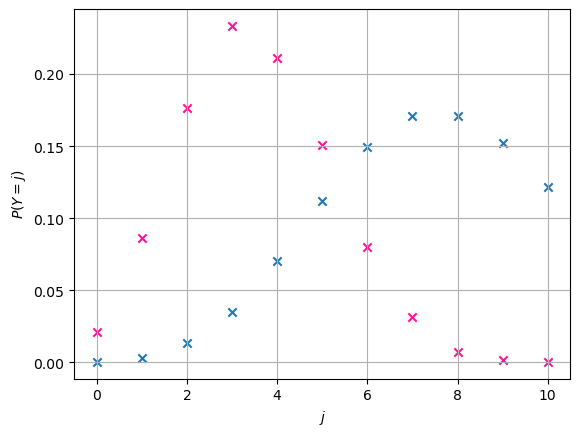

In [293]:
i_X_gibbs, X_gibbs_pdf = make_pdf(X_gibbs)
i_Y_gibbs, Y_gibbs_pdf = make_pdf(Y_gibbs)

plt.scatter(i_X_gibbs, X_gibbs_pdf, marker="x", color="c", label="Gibbs (X)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.grid()
plt.ylabel(r"$P(X=i)$")
plt.xlabel(r"$i$")
plt.show()
plt.scatter(i_Y_gibbs, Y_gibbs_pdf, marker="x", color="deeppink", label="Gibbs (Y)")
plt.scatter([i for i in range(0, 11)],true_pdf(8, 10), marker="x", label="Actual")
plt.grid()
plt.ylabel(r"$P(Y=j)$")
plt.xlabel(r"$j$")
plt.show()

Performing $\chi^2$ test

In [ ]:
chisq, p = chisquare(f_obs=[i*10000 for i in X_gibbs_pdf], f_exp=[i*10000 for i in true_pdf(8, 10)])
print("chi squared test. \u03B1 = 0.05")
print(f"Test statistic: {chisq}")
print(f"P-value: {p}")

Thinning...

### 3 - Bayesian Problem

- Omitted due to difficulty and time restrictions.